In [877]:
import geopandas as gpd
import pandas as pd
import shapely
import shapely
from fiona.crs import from_epsg
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import shapely.geometry as geom
import seaborn as sns
import pyproj
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from os import listdir
import ast
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Section 1: Feature Engineering

In this section we add features from ACS, PLUTO, NOAA Climate data and After Hour Variance(AHV) permits to the complaints.

## 1.1 311 Complaints in 2016 

We take 311 noise complaints handled by the DEP in 2016. This data was obtained from https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

In [878]:
df = pd.read_csv('2016_dep_noise.csv')
df['lonlat']=list(zip(df['Longitude'],df['Latitude']))
df['geometry']=df[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [879]:
df = gpd.GeoDataFrame(df)

In [880]:
df.crs = from_epsg(4326)
df = df.to_crs(epsg=2263)

In [881]:
df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location', 'lonlat', 'geometry'],
      dtype='object')

## 1.2 New York Zoning Districts

Here we obtain the zoning districts in the city which we assign to each complaint type using spatial join. This data was obtained from https://www1.nyc.gov/site/planning/data-maps/open-data.page#zoning_related NYC GIS Zoning features.

In [882]:
nyzd = gpd.GeoDataFrame.from_file('nyzd_2016.shp')

In [883]:
nyzd.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

In [884]:
nyzd.head()

,OBJECTID,ZONEDIST,Shape_Leng,Shape_Area,geometry
0,1,R5,1862.207446,1.943711e+05,"POLYGON ((960088.7548217773 175295.9550170898,..."
1,2,R5,19208.305164,2.767667e+06,"POLYGON ((960059.2919921875 174171.1077880859,..."
2,3,R6,2935.376415,5.333286e+05,"POLYGON ((961651.7064208984 174650.6450195312,..."
3,4,R4,3246.982638,5.797014e+05,"POLYGON ((961651.7064208984 174650.6450195312,..."
4,5,M1-1,1797.546542,1.966755e+05,"POLYGON ((960152.7944335938 174247.2684326172,..."


In [885]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,lonlat,geometry
0,34500485,10/09/2016 07:25:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10038.0,90 GOLD STREET,...,NaN,NaN,NaN,NaN,NaN,40.710083,-74.004332,"(40.71008329261251, -74.00433200407059)","(-74.0043320041, 40.7100832926)",POINT (983049.0000007071 197979.014400992)
1,34618125,10/25/2016 09:05:00 PM,10/29/2016 12:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Jack Hammering (NC2),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(nan, nan)",POINT (nan nan)
2,34403555,09/25/2016 12:35:00 AM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10463.0,2475 PALISADE AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.880502,-73.922381,"(40.880502135696986, -73.92238094836378)","(-73.9223809484, 40.8805021357)",POINT (1005713.999987205 260078.0144404332)
3,32375355,01/09/2016 11:34:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,11201.0,NaN,...,NaN,NaN,NaN,NaN,NaN,40.699659,-73.995690,"(40.699658677488266, -73.99569031190914)","(-73.9956903119, 40.6996586775)",POINT (985444.9999992915 194181.0143985467)
4,32405483,01/13/2016 12:51:00 PM,01/18/2016 08:10:00 PM,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,11229.0,1720 EAST 14 STREET,...,NaN,NaN,NaN,NaN,NaN,40.607419,-73.958987,"(40.607418548173825, -73.95898667787446)","(-73.9589866779, 40.6074185482)",POINT (995637.9999932736 160578.0143765831)


In [886]:
nyzd = nyzd.to_crs(epsg=2263)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


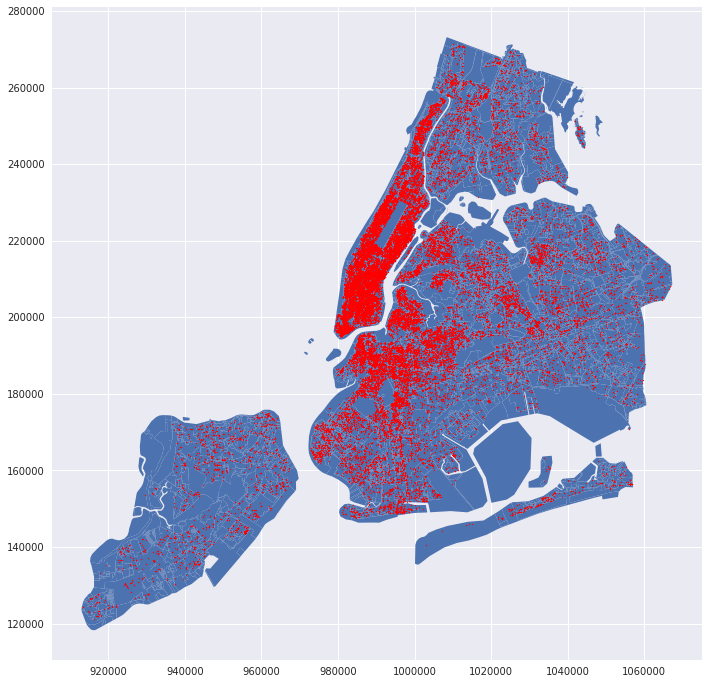

In [887]:
base = nyzd.plot(figsize=(12,12))
#base.axis('off')
df.plot(ax=base,color='red',markersize=1)

This plot just gives us visual confirmation that the complaints and the zoning districts are on same coordinates so that we wont lose any data in the spatial join.

In [888]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,lonlat,geometry
0,34500485,10/09/2016 07:25:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10038.0,90 GOLD STREET,...,NaN,NaN,NaN,NaN,NaN,40.710083,-74.004332,"(40.71008329261251, -74.00433200407059)","(-74.0043320041, 40.7100832926)",POINT (983049.0000007071 197979.014400992)
1,34618125,10/25/2016 09:05:00 PM,10/29/2016 12:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Jack Hammering (NC2),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(nan, nan)",POINT (nan nan)
2,34403555,09/25/2016 12:35:00 AM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,10463.0,2475 PALISADE AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.880502,-73.922381,"(40.880502135696986, -73.92238094836378)","(-73.9223809484, 40.8805021357)",POINT (1005713.999987205 260078.0144404332)
3,32375355,01/09/2016 11:34:00 PM,NaN,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,11201.0,NaN,...,NaN,NaN,NaN,NaN,NaN,40.699659,-73.995690,"(40.699658677488266, -73.99569031190914)","(-73.9956903119, 40.6996586775)",POINT (985444.9999992915 194181.0143985467)
4,32405483,01/13/2016 12:51:00 PM,01/18/2016 08:10:00 PM,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,11229.0,1720 EAST 14 STREET,...,NaN,NaN,NaN,NaN,NaN,40.607419,-73.958987,"(40.607418548173825, -73.95898667787446)","(-73.9589866779, 40.6074185482)",POINT (995637.9999932736 160578.0143765831)


In [889]:
df = df.dropna(subset=['Latitude','Longitude'])

In [890]:
df_zoned = gpd.sjoin(df,nyzd,how='left')

In [891]:
df_zoned.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location', 'lonlat', 'geometry',
       'index_right', 'OBJECTID', 'ZONEDIST', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

In [892]:
df_zoned.drop(['index_right'],axis=1,inplace=True)

## 1.3 Weather Data

Obtaining weather information in New York City for each of the days of complaints. The team at DEP conveyed to us that the volume of the complaints change over different seasons so we thought it would be useful to include this information. This information was accessed using the database from National Oceanic and Atmospheric Adminstration(NOAA) https://www.ncdc.noaa.gov/

In [893]:
weather_data = pd.read_csv('2016_weather.csv')

In [894]:
weather_data_ny = weather_data[['DATE','TAVG','SNWD','PRCP']]

In [895]:
weather_data_ny[['DATE','TAVG','SNWD','PRCP']].dropna()
weather_data_ny['DATE'] = pd.to_datetime(weather_data_ny['DATE']).dt.date
weather_data_ny.rename(columns={'DATE':'date','TAVG':'average_temparature','SNWD':'snow_levels','PRCP':'precipitation_levels'},\
                      inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [896]:
df_zoned['Created Date'] = pd.to_datetime(df_zoned['Created Date'])
df_zoned['Closed Date'] = pd.to_datetime(df_zoned['Closed Date'])

In [897]:
df_zoned['created_date_wo_time'] = df_zoned['Created Date'].dt.date
combined_df = df_zoned.merge(weather_data_ny,left_on='created_date_wo_time',right_on='date')

In [898]:
list(combined_df.sort_values(by='Resolution Description')['Resolution Description'].unique())

['The Department of Environmental Protection attempted to contact the complainant by phone, but the phone number provided was incorrect. If the problem still exists, please call 311 and file a new complaint with the correct phone number. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).',
 'The Department of Environmental Protection attempted to inspect this complaint but could not gain access to the location. If the problem still exists, please call 311 and file a new complaint with additional access information. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).',
 'The Department of Environmental Protection attempted to investigate this complaint but the address was incorrect. If the problem still exists, please call 311 and file a new complaint with the correct address. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).',
 "The Department of Environmental Protection closed or canceled this compl

In [899]:
combined_df['ZONEDIST'].unique()

array(['R8', 'R6A', 'R5D', 'R7-2', 'C4-7', 'R10', 'R7B', 'C6-1', 'C5-5',
       'R5B', 'R6B', 'R5', 'R1-2', 'R3X', 'R4-1', 'R6', 'R4', 'C1-9A',
       'M1-5/R7X', 'C6-3', 'R8B', 'C6-2', 'M2-3', 'R3-2', 'M1-2', 'C6-2A',
       'C4-3A', 'R8X', 'C4-5X', 'C5-2', 'C1-9', 'C4-4A', 'C6-1G', 'R7-1',
       'C1-8A', 'R8A', 'R7A', 'R4A', 'C6-4', 'C8-2', 'C2-8', 'M1-4D',
       'C2-8A', 'M3-1', 'R2', 'M1-6', 'C6-4A', 'M1-5B', 'M1-1', 'R3-1',
       'R10A', 'C2-7', 'C4-4L', 'M1-5', 'R2A', 'R4B', 'C5-1', 'C5-P',
       'M1-2/R6A', 'C4-4', 'C5-3', 'M2-1', 'R7X', 'C1-8X', 'C6-4X',
       'M1-5A', 'R5A', 'M1-5M', 'C6-2G', 'C5-1A', 'C4-5D', 'BPC', 'R3A',
       'C4-2', 'C4-6A', 'C6-6', 'C1-7', 'C6-5', 'C6-3A', 'R7-3', 'C6-4M',
       'C6-7', 'M1-5/R7-3', 'R1-2A', 'M3-2', 'C6-2M', 'C6-4.5', 'M1-4',
       'R9A', 'C4-6', 'C6-3X', 'C4-3', 'R10H', 'M1-2/R5D', 'C2-7A', 'R9X',
       'C5-2A', 'C1-6', 'M1-2/R6B', 'R9', 'C5-2.5', 'C4-2A', 'M1-2/R8',
       'C1-6A', 'C8-3', 'C6-6.5', 'C5-4', 'M1-6/R10', 'C6-1A'

Creating numerical labels for each of the string variables so that they can be input into the random forrest classifier.

In [900]:
zonedist_dict = {'R8':154, 'R8B':1, 'C4-5X':2, 'C5-5':3, 'R6A':4, 'R5D':5, 'M2-3':6, 'C1-8A':7,
       'C1-9A':8, 'M1-5/R7X':9, 'C5-2':10, 'R6':11, 'M1-2':12, 'C6-3':13, 'C4-7':14, 'C6-2A':15,
       'R6B':16, 'C6-1':17, 'R10':18, 'R1-2':19, 'R7B':20, 'R4':21, 'R7-2':22, 'C6-2':23, 'C1-9':24,
       'R5':25, 'R8X':26, 'R5B':27, 'R8A':28, 'C6-1G':29, 'R3X':30, 'R4-1':31, 'C4-4A':32, 'C4-3A':33,
       'R3-2':34, 'R7-1':35, 'C6-4':36, 'C6-3A':37, 'C5-2A':38, 'R7A':39, 'C5-3':40, 'R3A':41,
       'M1-5':42, 'M1-5A':43, 'C2-8':44, 'R3-1':45, 'C1-6A':46, 'R7D':47, 'C1-7':48, 'R10A':49,
       'C4-6A':50, 'C6-3X':51, 'C6-4X':52, 'C6-6.5':53, 'C6-9':54, 'M1-2/R6A':55, 'C4-4':56,
       'C4-2':57, 'R2':58, 'M1-1':59, 'M3-1':60, 'R2X':61, 'M1-4/R6A':62, 'R1-2A':63, 'R2A':64,
       'R4A':65, 'M1-5B':66, 'M1-5/R9':67, 'M1-6':68, 'C6-4A':69, 'M1-4':70, 'C6-6':71,
       'C6-4.5':72, 'C5-P':73, 'C5-1':74, 'C6-4M':75, 'R9A':76, 'M1-6D':77, 'C2-8A':78, 'C6-2G':79,
       'M1-1D':80, 'C1-6':81, 'R9':82, 'C1-8X':83, 'C5-2.5':84, 'C8-4':85, 'C4-4D':86, 'C1-8':87,
       'C8-1':88, 'M2-1':89, 'M1-6/R10':90, 'M1-5/R7-3':91, 'C4-6':92, 'C4-5A':93, 'C2-6':94,
       'M1-2D':95, 'BPC':96, 'M1-4/R6B':97, 'C6-7':98, 'R7-3':99, 'R4B':100, 'M1-2/R6B':101,
       'C4-3':102, 'C4-2A':103, 'R10H':104, 'M3-2':105, 'R1-1':106, 'C4-5':107, 'M1-2/R6':108, 'R5A':109,
       'PARK':110, 'C6-5':111, 'C5-4':112, 'M1-5M':113, 'C6-2M':114, 'C4-5D':115, 'R7X':116, 'C4-4L':117,
       'C2-7A':118, 'C8-2':119, 'M1-4/R7A':120, 'M2-4':121, 'C3A':122, 'M1-4D':123, 'C2-7':124,
       'C6-1A':125, 'C5-1A':126, 'M1-4/R8A':127, 'M1-2/R5D':128, 'C4-1':129, 'C6-7T':130, 'C6-5.5':131,
       'M1-4/R7-2':132, 'C1-7A':133, 'M1-2/R7A':134, 'C8-3':135, 'M1-4/R7X':136, 'R9X':137,
       'M1-2/R5B':138, 'M1-2/R8A':139, 'M1-3':140, 'M1-1/R7-2':141, 'M1-5/R8A':142, 'C4-2F':143,
       'C3':144, 'nan':0, 'M1-2/R8':145, 'C2-6A':146, 'M1-1/R5':147, 'M1-5/R9-1':148, 'C6-3D':149,
       'C7':150, 'M1-3/R7X':151, 'M1-3/R8':152, 'M1-5/R7-2':153}

In [901]:
descriptor_dict = {
    'Noise: Construction Before/After Hours (NM1)':0,
       'Noise: Alarms (NR3)':1, 'Noise: Boat(Engine,Music,Etc) (NR10)':2,
       'Noise: Construction Equipment (NC1)':3, 'Noise, Barking Dog (NR5)':4,
       'Noise: Jack Hammering (NC2)':5,
       'Noise: air condition/ventilation equipment (NV1)':6,
       'Noise, Ice Cream Truck (NR4)':7, 'Noise: Manufacturing Noise (NK1)':8,
       'Noise: Private Carting Noise (NQ1)':9,
       'Noise:  lawn care equipment (NCL)':10, 'Noise, Other Animals (NR6)':11,
       'Noise: Other Noise Sources (Use Comments) (NZZ)':12,
       'Noise: Loud Music/Nighttime(Mark Date And Time) (NP1)':13,
       'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)':14,
       'Noise: Vehicle (NR2)':15
}

# Priority mapping

Here we assign priority labels to the resolution descriptions. A priority score of 1 means that the DEP inspectors were able to visit the complaint site and address the source of noise. A score of 2 means that the DEP inspectors were not able to close the complaint upon visit. The complaints were dropped later as they were duplicates of other complaints or there was no description.

In [902]:
dict3 = {
    'The Department of Environmental Protection attempted to contact the complainant by phone, but the phone number provided was incorrect. If the problem still exists, please call 311 and file a new complaint with the correct phone number. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':2,
 'The Department of Environmental Protection attempted to inspect this complaint but could not gain access to the location. If the problem still exists, please call 311 and file a new complaint with additional access information. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':2,
 'The Department of Environmental Protection attempted to investigate this complaint but the address was incorrect. If the problem still exists, please call 311 and file a new complaint with the correct address. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':2,
 "The Department of Environmental Protection closed or canceled this complaint at the complainant's request.":2,
 'The Department of Environmental Protection conducted an inspection and determined that "No Horn Honking" or "No Idling" signs are not warranted. If the problem still exists, please call 311 and file a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':2,
 'The Department of Environmental Protection conducted an inspection and determined that "No Horn Honking" or "No Idling" signs are warranted. A request will be sent to the Department of Transportation to have the sign(s) installed.':1,
 'The Department of Environmental Protection determined that an inspection is not warranted to investigate this complaint at this time and sent a letter to the complainant and/or respondent.':2,
 'The Department of Environmental Protection determined that an inspection is warranted to investigate this complaint.':2,
 'The Department of Environmental Protection determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.':0,
 'The Department of Environmental Protection determined that this complaint is not under its jurisdiction and referred it to the New York Police Department for further action.':2,
 'The Department of Environmental Protection did not observe a violation of the New York City Air/Noise Code at the time of inspection and could not issue a notice of violation. If the problem still exists, please call 311 and file a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':2,
 'The Department of Environmental Protection has inspected your complaint and determined that further investigation is required. More information will be available once the condition is resolved. Please visit nyc.gov/311 or call 311 at a later time to check the status of your complaint.':2,
 'The Department of Environmental Protection investigated this complaint and made a repair.':1,
 'The Department of Environmental Protection investigated this complaint and shut the running hydrant.':1,
 'The Department of Environmental Protection observed a violation of the New York City Air/Noise Code at the time of inspection and issued a notice of violation.':1,
 'The Department of Environmental Protection received a letter or phone call from the alleged dog owner in response to a letter or inspection.':2,
 'The Department of Environmental Protection received a response from the complainant with additional information that was requested to assist in investigation of the complaint (see resolution code A22).':2,
 'The Department of Environmental Protection requires an appointment to inspect this complaint type.  Complainant information was not provided and an appointment could not be scheduled.  The complaint has been closed. If the problem still exists, please call 311 and file a new complaint including your contact information.':2,
 'The Department of Environmental Protection requires contact with the complainant to investigate this complaint. A message was left for the complainant at the phone number provided.':2,
 'The Department of Environmental Protection requires contact with the complainant to investigate this complaint. The complaint was closed because attempts made to contact the complainant by phone and/or letter received no response.':2,
 'The Department of Environmental Protection researched this complaint and determined that it could be closed.':2,
 'The Department of Environmental Protection resolved this complaint by speaking to the complainant on the phone.':2,
 'The Department of Environmental Protection scheduled an inspection.':2,
 'The Department of Environmental Protection sent a letter to the complainant and/or respondent and the letter was returned as undeliverable.':2,
 'The status of this Service Request is currently not available online. Please call 311 for further assistance. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).':0,
    'nan':0
}

In [903]:
combined_df['enforcability_score'] = combined_df['Resolution Description'].apply(lambda x: dict3[str(x)])
combined_df['Descriptor_cat'] = combined_df['Descriptor'].apply(lambda x: descriptor_dict[str(x)])
combined_df['zonedist_cat'] = combined_df['ZONEDIST'].apply(lambda x: zonedist_dict[str(x)])

In [904]:
filtered_combined_df = combined_df[combined_df['enforcability_score'] != 0]
filtered_combined_df = filtered_combined_df[filtered_combined_df['zonedist_cat'] != 0]

In [905]:
filtered_combined_df.Descriptor.unique()

array(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Alarms (NR3)', 'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)', 'Noise, Barking Dog (NR5)',
       'Noise: Boat(Engine,Music,Etc) (NR10)',
       'Noise: air condition/ventilation equipment (NV1)',
       'Noise, Ice Cream Truck (NR4)', 'Noise:  lawn care equipment (NCL)',
       'Noise, Other Animals (NR6)', 'Noise: Private Carting Noise (NQ1)',
       'Noise: Manufacturing Noise (NK1)',
       'Noise: Other Noise Sources (Use Comments) (NZZ)',
       'Noise: Loud Music/Nighttime(Mark Date And Time) (NP1)',
       'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)',
       'Noise: Vehicle (NR2)'], dtype=object)

# AHV Files

For each of the construction related complaints we checked if there was an open after hour variance permit within 200 metres radius from the complaint. These files were created in other notebooks and compiled below.

In [906]:
counter = 0
for file in listdir('ahv_assigned_files'):
    filename = 'ahv_assigned_files/'+file
    if counter == 0:
        ahv_assigned = pd.read_csv(filename)
        counter += 1
    else:
        ahv_assigned = pd.concat([ahv_assigned,pd.read_csv(filename)])

In [907]:
ahv_assigned.shape

(39688, 44)

In [908]:
ahv_assigned = ahv_assigned[['Unique Key','AHV']]

In [909]:
filtered_combined_df_with_AHV =  filtered_combined_df.merge(ahv_assigned,how='left',on='Unique Key')

In [910]:
filtered_combined_df_with_AHV.AHV.fillna(value=0,inplace=True)

## Adding American Community Survey features and PLUTO features

We decided that adding PLUTO features and American Community Survey features would inform us better. Since this will lead to overfitting we plan to take the ten most important features and evaluate the performance with the subset. 

In [911]:
pluto_features = gpd.GeoDataFrame.from_file('pluto_cbg.geojson')
pluto_features.drop(['GEOID'],axis=1,inplace=True)

In [912]:
pluto_features = pluto_features.to_crs(epsg=2263)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


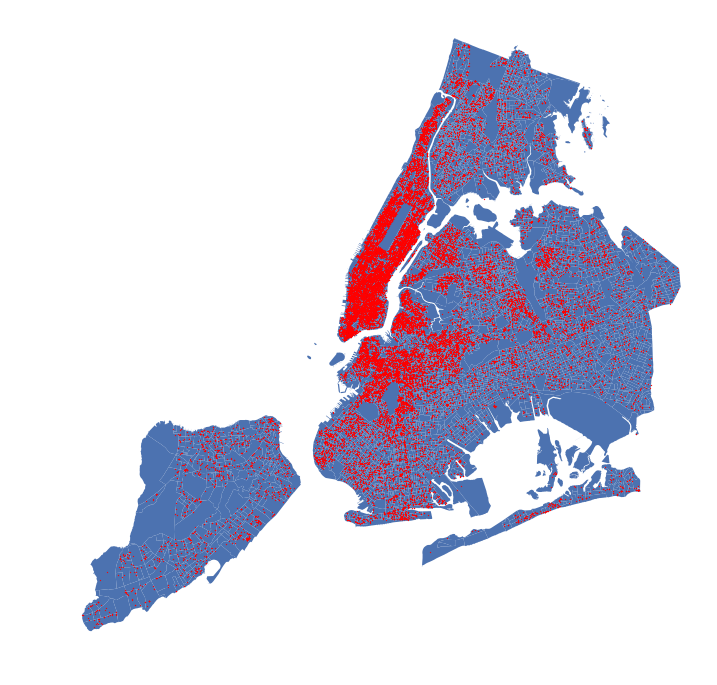

In [913]:
base = pluto_features.plot(figsize=(12,12))
base.axis('off')
filtered_combined_df_with_AHV.plot(ax=base,color='red',markersize=1)

In [914]:
pluto_features.columns

Index(['lotarea', 'numfloors', 'unitsres', 'unitstotal', 'lotfront',
       'lotdepth', 'bldgfront', 'bldgdepth', 'assessland', 'yearbuilt',
       'builtfar', 'residfar', 'commfar', 'facilfar', 'overlay1', 'bldgclass',
       'landuse', 'lottype', 'simple_zone', 'geometry'],
      dtype='object')

In [915]:
overlay1_dict = {'U':0, 'C1':1, 'C2':2}
bldgclass_dict = {'C':0, 'A':1, 'B':2, 'D':3, 'K':4, 'Z':5, 'G':6, 'S':7, 'P':8, 'R':9, 'T':10, 'F':11, 'O':12,\
       'I':13, 'U':14, 'E':15, 'W':16, 'Q':17, 'M':18, 'Y':19, 'H':20, 'J':21, 'V':22, 'N':23, 'L':24}
simple_zone_dict = {'R7':0, 'R6':1, 'R5':2, 'M1':3, 'C4':4, 'R8':5, 'R4':6, 'R3':7, 'R2':8, 'C7':9, 'C8':10,\
       'O':11, 'M3':12, 'C5':13, 'C6':14, 'R10':15, 'R1':16, 'C1':17, 'R9':18, 'M2':19, 'P':20, 'C2':21,
       'C3':22}

In [916]:
pluto_features['overlay1_cat'] = pluto_features['overlay1'].apply(lambda x:overlay1_dict[x])
pluto_features['bldgclass_cat'] = pluto_features['bldgclass'].apply(lambda x:bldgclass_dict[x])
pluto_features['simple_zone_cat'] = pluto_features['simple_zone'].apply(lambda x:simple_zone_dict[x])

In [917]:
census_df_all_features = gpd.GeoDataFrame.from_file('acs_2016_demo.shp')
# https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.2016.html

In [918]:
census_df_all_features = census_df_all_features.to_crs(epsg=2263)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


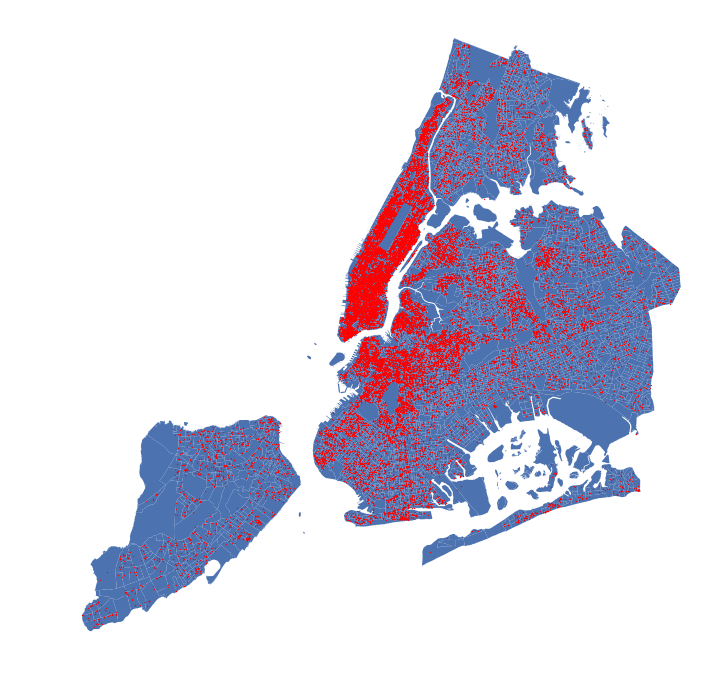

In [919]:
base = census_df_all_features.plot(figsize=(12,12))
base.axis('off')
filtered_combined_df_with_AHV.plot(ax=base,color='red',markersize=1)

In [921]:
filtered_combined_df_added_census = gpd.sjoin(filtered_combined_df_with_AHV, census_df_all_features,how='left')

In [926]:
filtered_combined_df_added_census['hour_of_the_day'] = filtered_combined_df_added_census['Created Date'].dt.hour

In [928]:
#filtered_combined_df_added_census.drop(['index_right'],axis=1,inplace=True)
filtered_combined_df_added_census_pluto = gpd.sjoin(filtered_combined_df_added_census,pluto_features,how='left')

In [929]:
input_features = ['hour_of_the_day',
 'average_temparature', 'snow_levels', 'precipitation_levels', 'Descriptor_cat', 'zonedist_cat', 'AHV', 'B02001e1',
 'B02001m1', 'B02001e2', 'B02001m2', 'B02001e3', 'B02001m3', 'B02001e4', 'B02001m4', 'B02001e5', 'B02001m5', 'B02001e6',
 'B02001m6', 'B02001e7', 'B02001m7', 'B02001e8', 'B02001m8', 'B02001e9', 'B02001m9', 'B02001e10', 'B02001m10', 'B02008e1',
 'B02008m1', 'B02009e1', 'B02009m1', 'B02010e1', 'B02010m1', 'B02011e1', 'B02011m1', 'B02012e1', 'B02012m1', 'B02013e1',
 'B02013m1', 'C02003e1', 'C02003m1', 'C02003e2', 'C02003m2', 'C02003e3', 'C02003m3', 'C02003e4', 'C02003m4', 'C02003e5',
 'C02003m5', 'C02003e6', 'C02003m6', 'C02003e7', 'C02003m7', 'C02003e8', 'C02003m8', 'C02003e9', 'C02003m9', 'C02003e10',
 'C02003m10', 'C02003e11', 'C02003m11', 'C02003e12', 'C02003m12', 'C02003e13', 'C02003m13', 'C02003e14', 'C02003m14',
 'C02003e15', 'C02003m15', 'C02003e16', 'C02003m16', 'C02003e17', 'C02003m17', 'C02003e18', 'C02003m18', 'C02003e19',
 'C02003m19', 'B01001e1', 'B01001m1', 'B01001e2', 'B01001m2', 'B01001e3', 'B01001m3', 'B01001e4', 'B01001m4', 'B01001e5',
 'B01001m5', 'B01001e6', 'B01001m6', 'B01001e7', 'B01001m7', 'B01001e8', 'B01001m8', 'B01001e9', 'B01001m9', 'B01001e10',
 'B01001m10', 'B01001e11', 'B01001m11', 'B01001e12', 'B01001m12', 'B01001e13', 'B01001m13', 'B01001e14', 'B01001m14',
 'B01001e15', 'B01001m15', 'B01001e16', 'B01001m16', 'B01001e17', 'B01001m17', 'B01001e18', 'B01001m18', 'B01001e19',
 'B01001m19', 'B01001e20', 'B01001m20', 'B01001e21', 'B01001m21', 'B01001e22', 'B01001m22', 'B01001e23', 'B01001m23',
 'B01001e24', 'B01001m24', 'B01001e25', 'B01001m25', 'B01001e26', 'B01001m26', 'B01001e27', 'B01001m27', 'B01001e28',
 'B01001m28', 'B01001e29', 'B01001m29', 'B01001e30', 'B01001m30', 'B01001e31', 'B01001m31', 'B01001e32', 'B01001m32',
 'B01001e33', 'B01001m33', 'B01001e34', 'B01001m34', 'B01001e35', 'B01001m35', 'B01001e36', 'B01001m36', 'B01001e37',
 'B01001m37', 'B01001e38', 'B01001m38', 'B01001e39', 'B01001m39', 'B01001e40', 'B01001m40', 'B01001e41', 'B01001m41',
 'B01001e42', 'B01001m42', 'B01001e43', 'B01001m43', 'B01001e44', 'B01001m44', 'B01001e45', 'B01001m45', 'B01001e46',
 'B01001m46', 'B01001e47', 'B01001m47', 'B01001e48', 'B01001m48', 'B01001e49', 'B01001m49', 'B01002e1', 'B01002m1',
 'B01002e2', 'B01002m2', 'B01002e3', 'B01002m3', 'B01002Ae1', 'B01002Am1', 'B01002Ae2', 'B01002Am2', 'B01002Ae3',
 'B01002Am3', 'B01002Be1', 'B01002Bm1', 'B01002Be2', 'B01002Bm2', 'B01002Be3', 'B01002Bm3', 'B01002Ce1', 'B01002Cm1',
 'B01002Ce2', 'B01002Cm2','B01002Ce3', 'B01002Cm3', 'B01002De1', 'B01002Dm1', 'B01002De2', 'B01002Dm2', 'B01002De3',
 'B01002Dm3',
 'B01002Ee1',
 'B01002Em1',
 'B01002Ee2',
 'B01002Em2',
 'B01002Ee3',
 'B01002Em3',
 'B01002Fe1',
 'B01002Fm1',
 'B01002Fe2',
 'B01002Fm2',
 'B01002Fe3',
 'B01002Fm3',
 'B01002Ge1',
 'B01002Gm1',
 'B01002Ge2',
 'B01002Gm2',
 'B01002Ge3',
 'B01002Gm3',
 'B01002He1',
 'B01002Hm1',
 'B01002He2',
 'B01002Hm2',
 'B01002He3',
 'B01002Hm3',
 'B01002Ie1',
 'B01002Im1',
 'B01002Ie2',
 'B01002Im2',
 'B01002Ie3',
 'B01002Im3',
 'B01003e1',
 'B01003m1',
 'B19001e1',
 'B19001m1',
 'B19001e2',
 'B19001m2',
 'B19001e3',
 'B19001m3',
 'B19001e4',
 'B19001m4',
 'B19001e5',
 'B19001m5',
 'B19001e6',
 'B19001m6',
 'B19001e7',
 'B19001m7',
 'B19001e8',
 'B19001m8',
 'B19001e9',
 'B19001m9',
 'B19001e10',
 'B19001m10',
 'B19001e11',
 'B19001m11',
 'B19001e12',
 'B19001m12',
 'B19001e13',
 'B19001m13',
 'B19001e14',
 'B19001m14',
 'B19001e15',
 'B19001m15',
 'B19001e16',
 'B19001m16',
 'B19001e17',
 'B19001m17',
 'B19013e1',
 'B19013m1',
 'B19025e1',
 'B19025m1',
 'B19025Ae1',
 'B19025Am1',
 'B19025Be1',
 'B19025Bm1',
 'B19025Ce1',
 'B19025Cm1',
 'B19025De1',
 'B19025Dm1',
 'B19025Ee1',
 'B19025Em1',
 'B19025Fe1',
 'B19025Fm1',
 'B19025Ge1',
 'B19025Gm1',
 'B19025He1',
 'B19025Hm1',
 'B19025Ie1',
 'B19025Im1',
 'B19037e1',
 'B19037m1',
 'B19037e2',
 'B19037m2',
 'B19037e3',
 'B19037m3',
 'B19037e4',
 'B19037m4',
 'B19037e5',
 'B19037m5',
 'B19037e6',
 'B19037m6',
 'B19037e7',
 'B19037m7',
 'B19037e8',
 'B19037m8',
 'B19037e9',
 'B19037m9',
 'B19037e10',
 'B19037m10',
 'B19037e11',
 'B19037m11',
 'B19037e12',
 'B19037m12',
 'B19037e13',
 'B19037m13',
 'B19037e14',
 'B19037m14',
 'B19037e15',
 'B19037m15',
 'B19037e16',
 'B19037m16',
 'B19037e17',
 'B19037m17',
 'B19037e18',
 'B19037m18',
 'B19037e19',
 'B19037m19',
 'B19037e20',
 'B19037m20',
 'B19037e21',
 'B19037m21',
 'B19037e22',
 'B19037m22',
 'B19037e23',
 'B19037m23',
 'B19037e24',
 'B19037m24',
 'B19037e25',
 'B19037m25',
 'B19037e26',
 'B19037m26',
 'B19037e27',
 'B19037m27',
 'B19037e28',
 'B19037m28',
 'B19037e29',
 'B19037m29',
 'B19037e30',
 'B19037m30',
 'B19037e31',
 'B19037m31',
 'B19037e32',
 'B19037m32',
 'B19037e33',
 'B19037m33',
 'B19037e34',
 'B19037m34',
 'B19037e35',
 'B19037m35',
 'B19037e36',
 'B19037m36',
 'B19037e37',
 'B19037m37',
 'B19037e38',
 'B19037m38',
 'B19037e39',
 'B19037m39',
 'B19037e40',
 'B19037m40',
 'B19037e41',
 'B19037m41',
 'B19037e42',
 'B19037m42',
 'B19037e43',
 'B19037m43',
 'B19037e44',
 'B19037m44',
 'B19037e45',
 'B19037m45',
 'B19037e46',
 'B19037m46',
 'B19037e47',
 'B19037m47',
 'B19037e48',
 'B19037m48',
 'B19037e49',
 'B19037m49',
 'B19037e50',
 'B19037m50',
 'B19037e51',
 'B19037m51',
 'B19037e52',
 'B19037m52',
 'B19037e53',
 'B19037m53',
 'B19037e54',
 'B19037m54',
 'B19037e55',
 'B19037m55',
 'B19037e56',
 'B19037m56',
 'B19037e57',
 'B19037m57',
 'B19037e58',
 'B19037m58',
 'B19037e59',
 'B19037m59',
 'B19037e60',
 'B19037m60',
 'B19037e61',
 'B19037m61',
 'B19037e62',
 'B19037m62',
 'B19037e63',
 'B19037m63',
 'B19037e64',
 'B19037m64',
 'B19037e65',
 'B19037m65',
 'B19037e66',
 'B19037m66',
 'B19037e67',
 'B19037m67',
 'B19037e68',
 'B19037m68',
 'B19037e69',
 'B19037m69',
 'B19049e1',
 'B19049m1',
 'B19049e2',
 'B19049m2',
 'B19049e3',
 'B19049m3',
 'B19049e4',
 'B19049m4',
 'B19049e5',
 'B19049m5',
 'B19050e1',
 'B19050m1',
 'B19050e2',
 'B19050m2',
 'B19050e3',
 'B19050m3',
 'B19050e4',
 'B19050m4',
 'B19050e5',
 'B19050m5',
 'B19051e1',
 'B19051m1',
 'B19051e2',
 'B19051m2',
 'B19051e3',
 'B19051m3',
 'B19052e1',
 'B19052m1',
 'B19052e2',
 'B19052m2',
 'B19052e3',
 'B19052m3',
 'B19053e1',
 'B19053m1',
 'B19053e2',
 'B19053m2',
 'B19053e3',
 'B19053m3',
 'B19054e1',
 'B19054m1',
 'B19054e2',
 'B19054m2',
 'B19054e3',
 'B19054m3',
 'B19055e1',
 'B19055m1',
 'B19055e2',
 'B19055m2',
 'B19055e3',
 'B19055m3',
 'B19056e1',
 'B19056m1',
 'B19056e2',
 'B19056m2',
 'B19056e3',
 'B19056m3',
 'B19057e1',
 'B19057m1',
 'B19057e2',
 'B19057m2',
 'B19057e3',
 'B19057m3',
 'B19059e1',
 'B19059m1',
 'B19059e2',
 'B19059m2',
 'B19059e3',
 'B19059m3',
 'B19060e1',
 'B19060m1',
 'B19060e2',
 'B19060m2',
 'B19060e3',
 'B19060m3',
 'B19061e1',
 'B19061m1',
 'B19062e1',
 'B19062m1',
 'B19063e1',
 'B19063m1',
 'B19064e1',
 'B19064m1',
 'B19065e1',
 'B19065m1',
 'B19066e1',
 'B19066m1',
 'B19067e1',
 'B19067m1',
 'B19069e1',
 'B19069m1',
 'B19070e1',
 'B19070m1',
 'B19101e1',
 'B19101m1',
 'B19101e2',
 'B19101m2',
 'B19101e3',
 'B19101m3',
 'B19101e4',
 'B19101m4',
 'B19101e5',
 'B19101m5',
 'B19101e6',
 'B19101m6',
 'B19101e7',
 'B19101m7',
 'B19101e8',
 'B19101m8',
 'B19101e9',
 'B19101m9',
 'B19101e10',
 'B19101m10',
 'B19101e11',
 'B19101m11',
 'B19101e12',
 'B19101m12',
 'B19101e13',
 'B19101m13',
 'B19101e14',
 'B19101m14',
 'B19101e15',
 'B19101m15',
 'B19101e16',
 'B19101m16',
 'B19101e17',
 'B19101m17',
 'B19127e1',
 'B19127m1',
 'B19201e1',
 'B19201m1',
 'B19201e2',
 'B19201m2',
 'B19201e3',
 'B19201m3',
 'B19201e4',
 'B19201m4',
 'B19201e5',
 'B19201m5',
 'B19201e6',
 'B19201m6',
 'B19201e7',
 'B19201m7',
 'B19201e8',
 'B19201m8',
 'B19201e9',
 'B19201m9',
 'B19201e10',
 'B19201m10',
 'B19201e11',
 'B19201m11',
 'B19201e12',
 'B19201m12',
 'B19201e13',
 'B19201m13',
 'B19201e14',
 'B19201m14',
 'B19201e15',
 'B19201m15',
 'B19201e16',
 'B19201m16',
 'B19201e17',
 'B19201m17',
 'B19202e1',
 'B19202m1',
 'B19214e1',
 'B19214m1',
 'B19301e1',
 'B19301m1',
 'B19301Ae1',
 'B19301Am1',
 'B19301Be1',
 'B19301Bm1',
 'B19301Ce1',
 'B19301Cm1',
 'B19301De1',
 'B19301Dm1',
 'B19301Ee1',
 'B19301Em1',
 'B19301Fe1',
 'B19301Fm1',
 'B19301Ge1',
 'B19301Gm1',
 'B19301He1',
 'B19301Hm1',
 'B19301Ie1',
 'B19301Im1',
 'B19313e1',
 'B19313m1',
 'B19313Ae1',
 'B19313Am1',
 'B19313Be1',
 'B19313Bm1',
 'B19313Ce1',
 'B19313Cm1',
 'B19313De1',
 'B19313Dm1',
 'B19313Ee1',
 'B19313Em1',
 'B19313Fe1',
 'B19313Fm1',
 'B19313Ge1',
 'B19313Gm1',
 'B19313He1',
 'B19313Hm1',
 'B19313Ie1',
 'B19313Im1',
 'B00001e1',
 'B00001m1',
 'B00002e1',
 'B00002m1','lotarea', 'numfloors', 'unitsres', 'unitstotal', 'lotfront',\
       'lotdepth', 'bldgfront', 'bldgdepth', 'assessland', 'yearbuilt',\
       'builtfar', 'residfar', 'commfar', 'facilfar', 'overlay1_cat', 'bldgclass_cat',\
       'landuse', 'lottype', 'simple_zone_cat']

# Section 2: Modelling

## Testing for all complaints and all features

In [930]:
filtered_combined_df_added_census_pluto = filtered_combined_df_added_census_pluto\
[input_features+['enforcability_score']].dropna()

In [931]:
def f_score(A):
    '''This function calculates the F-Score given the confusion matrix as input
    Input: 2*2 confusion matrix
    Output: F-Score
    '''
    pr = A[0][0]/(A[0][0]+A[0][1])
    re = A[0][0]/(A[0][0]+A[1][0])
    score = (2*pr*re)/(pr+re)
    print(score)

In [932]:
x_train, x_test, y_train, y_test = train_test_split(filtered_combined_df_added_census_pluto[input_features],
                                                    filtered_combined_df_added_census_pluto['enforcability_score'],
                                                           test_size = 0.3,random_state=42)

In [933]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [934]:
model_with_all_features.score(x_test,y_test)

0.96381294964028774

In [935]:
y_pred = model_with_all_features.predict(x_test)

In [936]:
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[   45,   106],
       [  397, 13352]])

In [937]:
f_score(confusion_matrix(y_pred,y_test))

0.151770657673


In [938]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.10180995475113122

In [939]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.29801324503311261

## Testing for all complaints and selected features

We select the top ten features by feature importance and train using these features.

In [940]:
feature_importance = pd.DataFrame(np.array([x_train.columns,model_with_all_features.feature_importances_]).T,\
                                  columns=['Features','Importance'])
selected_columns = list(feature_importance.sort_values(by='Importance',ascending=False)[:10].Features)

In [941]:
x_train, x_test, y_train, y_test = train_test_split(filtered_combined_df_added_census_pluto[selected_columns],
                                                    filtered_combined_df_added_census_pluto['enforcability_score'],
                                                           test_size = 0.3,random_state=42)

In [942]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [943]:
model_with_all_features.score(x_test,y_test)

0.96784172661870504

In [944]:
y_pred = model_with_all_features.predict(x_test)

In [945]:
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[   28,    33],
       [  414, 13425]])

In [946]:
f_score(confusion_matrix(y_pred,y_test))

0.111332007952


In [947]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.063348416289592757

In [948]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.45901639344262296

## Testing for all construction complaints and all features

We select the top ten features by feature importance and train using these features.

In [949]:
descriptor_dict

{'Noise, Barking Dog (NR5)': 4,
 'Noise, Ice Cream Truck (NR4)': 7,
 'Noise, Other Animals (NR6)': 11,
 'Noise:  lawn care equipment (NCL)': 10,
 'Noise: Alarms (NR3)': 1,
 'Noise: Boat(Engine,Music,Etc) (NR10)': 2,
 'Noise: Construction Before/After Hours (NM1)': 0,
 'Noise: Construction Equipment (NC1)': 3,
 'Noise: Jack Hammering (NC2)': 5,
 'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)': 14,
 'Noise: Loud Music/Nighttime(Mark Date And Time) (NP1)': 13,
 'Noise: Manufacturing Noise (NK1)': 8,
 'Noise: Other Noise Sources (Use Comments) (NZZ)': 12,
 'Noise: Private Carting Noise (NQ1)': 9,
 'Noise: Vehicle (NR2)': 15,
 'Noise: air condition/ventilation equipment (NV1)': 6}

In [950]:
x_train, x_test, y_train, y_test = train_test_split(\
                                                    filtered_combined_df_added_census_pluto[\
                                                                                            filtered_combined_df_added_census_pluto\
                                                                                            .Descriptor_cat.isin\
                                                                                            ([0,3,5])][input_features],
                                                    filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                            .Descriptor_cat.isin\
                                                                                            ([0,3,5])]['enforcability_score'],
                                                           test_size = 0.3,random_state=42)

In [951]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [952]:
model_with_all_features.score(x_test,y_test)

0.96511373578302717

In [953]:
y_pred = model_with_all_features.predict(x_test)

In [954]:
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[  40,   69],
       [ 250, 8785]])

In [955]:
f_score(confusion_matrix(y_pred,y_test))

0.200501253133


In [956]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.13793103448275862

In [957]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.3669724770642202

## Testing for all construction complaints and all selected features

In [958]:
feature_importance = pd.DataFrame(np.array([x_train.columns,model_with_all_features.feature_importances_]).T,\
                                  columns=['Features','Importance'])
selected_columns = list(feature_importance.sort_values(by='Importance',ascending=False)[:10].Features)

In [959]:
x_train, x_test, y_train, y_test = train_test_split(\
                                                    filtered_combined_df_added_census_pluto[\
                                                                                            filtered_combined_df_added_census_pluto.\
                                                                                            Descriptor_cat.isin\
                                                                                            ([0,3,5])][input_features],
                                                    filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto.\
                                                                                            Descriptor_cat.isin\
                                                                                            ([0,3,5])]['enforcability_score'],
                                                           test_size = 0.3,random_state=42)

In [960]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [961]:
model_with_all_features.score(x_test,y_test)

0.96511373578302717

In [962]:
y_pred = model_with_all_features.predict(x_test)

In [963]:
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[  40,   69],
       [ 250, 8785]])

In [964]:
f_score(confusion_matrix(y_pred,y_test))

0.200501253133


In [965]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.13793103448275862

In [966]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.3669724770642202

Here we see the recall is very low. This is because the training data contains a small number of enforceable complaints compared to unenforceable complaints. This gave us the idea to train on a sample of data that contains an equal number of enforceable and unenforceable complaints. This step would improve our recall but likely reduce our precision.

## Testing for all types complaints and all features(training on equal subset of enforceable and unenforceable complaints)

In [967]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                      .enforcability_score == 1][input_features],
                                                    filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                      .enforcability_score == 1]['enforcability_score'],
                                                           test_size = 0.3,random_state=42)
unenforcable_data = filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto.enforcability_score == 2].sample(n=1470)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(unenforcable_data[input_features],
                                                    unenforcable_data['enforcability_score'],
                                                           test_size = 0.3,random_state=42)
                                                    

In [968]:
x_train = pd.concat([x_train_1,x_train_2])
x_test = pd.concat([x_test_1,x_test_2])
y_train = pd.concat([y_train_1,y_train_2])
y_test = pd.concat([y_test_1,y_test_2])

In [969]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [970]:
model_with_all_features.score(x_test,y_test)

0.60997732426303852

In [971]:
y_pred = model_with_all_features.predict(x_test)

In [972]:
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[281, 184],
       [160, 257]])

In [973]:
f_score(conf_mat)

0.620309050773


In [974]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.63718820861678005

In [975]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.60430107526881716

In [976]:
subset = filtered_combined_df_added_census_pluto.sample(n=1000,random_state=42)
conf_mat = confusion_matrix(model_with_all_features.predict(subset[input_features]),
                 subset['enforcability_score'])
conf_mat

array([[ 18, 423],
       [  1, 558]])

In [977]:
f_score(confusion_matrix(model_with_all_features.predict(subset[input_features]),
                 subset['enforcability_score']))

0.0782608695652


In [978]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.94736842105263153

In [979]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.040816326530612242

## Testing for all complaints and selected features(training on equal subset of enforceable and unenforceable complaints)

In [980]:
feature_importance = pd.DataFrame(np.array([x_train.columns,model_with_all_features.feature_importances_]).T,\
                                  columns=['Features','Importance'])
final_selected_columns = list(feature_importance.sort_values(by='Importance',ascending=False)[:10].Features)

In [981]:
feature_importance[:10]

,Features,Importance
0,hour_of_the_day,0.0669148
1,average_temparature,0.0501819
2,snow_levels,0.00320779
3,precipitation_levels,0.0197687
4,Descriptor_cat,0.0413662
5,zonedist_cat,0.0197845
6,AHV,0.0136673
7,B02001e1,0.00119448
8,B02001m1,0.00166207
9,B02001e2,0.00119356


In [982]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                      .enforcability_score == 1][final_selected_columns],
                                                    filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                      .enforcability_score == 1]['enforcability_score'],
                                                           test_size = 0.3,random_state=42)
unenforcable_data = filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto.enforcability_score == 2].sample(n=1470)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(unenforcable_data[final_selected_columns],
                                                    unenforcable_data['enforcability_score'],
                                                           test_size = 0.3,random_state=42)
                                                    

In [983]:
x_train = pd.concat([x_train_1,x_train_2])
x_test = pd.concat([x_test_1,x_test_2])
y_train = pd.concat([y_train_1,y_train_2])
y_test = pd.concat([y_test_1,y_test_2])

In [984]:
final_model_with_selected = RandomForestClassifier(random_state=0,n_estimators=100)
final_model_with_selected.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [985]:
final_model_with_selected.score(x_test,y_test)

0.71768707482993199

In [986]:
y_pred = final_model_with_selected.predict(x_test)

In [987]:
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[344, 152],
       [ 97, 289]])

In [988]:
f_score(conf_mat)

0.734258271078


In [989]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.78004535147392295

In [990]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.69354838709677424

In [991]:
subset = filtered_combined_df_added_census_pluto.sample(n=1000,random_state=42)
conf_mat = confusion_matrix(final_model_with_selected.predict(subset[final_selected_columns]),
                 subset['enforcability_score'])
conf_mat

array([[ 17, 374],
       [  2, 607]])

In [992]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.89473684210526316

In [993]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.043478260869565216

In [994]:
f_score(confusion_matrix(final_model_with_selected.predict(subset[final_selected_columns]),
                 subset['enforcability_score']))

0.0829268292683


## Testing for construction with all features(training on equal subset of enforceable and unenforceable complaints)

In [995]:
construction_complaints_all_features = filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                               .Descriptor_cat.isin([0,3,5])]

In [996]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(construction_complaints_all_features[construction_complaints_all_features\
                                                                                      .enforcability_score == 1][input_features],
                                                    construction_complaints_all_features[construction_complaints_all_features\
                                                                                      .enforcability_score == 1]['enforcability_score'],
                                                           test_size = 0.3,random_state=42)
unenforcable_data = construction_complaints_all_features[construction_complaints_all_features.enforcability_score == 2].sample(n=957)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(unenforcable_data[input_features],
                                                    unenforcable_data['enforcability_score'],
                                                           test_size = 0.3,random_state=42)
                                                    

In [997]:
x_train = pd.concat([x_train_1,x_train_2])
x_test = pd.concat([x_test_1,x_test_2])
y_train = pd.concat([y_train_1,y_train_2])
y_test = pd.concat([y_test_1,y_test_2])

In [998]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [999]:
model_with_all_features.score(x_test,y_test)

0.60069444444444442

In [1000]:
y_pred = model_with_all_features.predict(x_test)

In [1001]:
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[172, 114],
       [116, 174]])

In [1002]:
f_score(confusion_matrix(y_pred,y_test))

0.599303135889


In [1003]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.59722222222222221

In [1004]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.60139860139860135

In [1005]:
subset = construction_complaints_all_features.sample(n=1000,random_state=42)
conf_mat = confusion_matrix(model_with_all_features.predict(subset[input_features]),
                 subset['enforcability_score'])

In [1006]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.88888888888888884

In [1007]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.051724137931034482

In [1008]:
f_score(confusion_matrix(model_with_all_features.predict(subset[input_features]),
                 subset['enforcability_score']))

0.0977596741344


In [1009]:
filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto.enforcability_score == 1].shape

(1470, 661)

In [1010]:
filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto.enforcability_score == 2].shape

(44862, 661)

In [1011]:
feature_importance = pd.DataFrame(np.array([x_train.columns,model_with_all_features.feature_importances_]).T,\
                                  columns=['Features','Importance'])

In [1012]:
selected_columns = list(feature_importance.sort_values(by='Importance',ascending=False)[:10].Features)

In [1013]:
selected_columns

['hour_of_the_day',
 'average_temparature',
 'zonedist_cat',
 'precipitation_levels',
 'Descriptor_cat',
 'AHV',
 'lotfront',
 'snow_levels',
 'residfar',
 'yearbuilt']

In [1014]:
construction_complaints_all_features[construction_complaints_all_features['AHV'] == 0].shape

(2771, 661)

In [1015]:
construction_complaints_all_features[(construction_complaints_all_features['AHV'] == 1) & \
                                     (construction_complaints_all_features['enforcability_score'] == 1)].shape

(850, 661)

## Testing for just construction complaints and selected features(training on equal subset of enforceable and unenforceable complaints)

In [1016]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(construction_complaints_all_features[construction_complaints_all_features\
                                                                                      .enforcability_score == 1][selected_columns],
                                                    construction_complaints_all_features[construction_complaints_all_features\
                                                                                      .enforcability_score == 1]['enforcability_score'],
                                                           test_size = 0.3,random_state=42)
unenforcable_data = construction_complaints_all_features[construction_complaints_all_features.enforcability_score == 2].sample(n=957)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(unenforcable_data[selected_columns],
                                                    unenforcable_data['enforcability_score'],
                                                           test_size = 0.3,random_state=42)
                                                    

In [1017]:
x_train = pd.concat([x_train_1,x_train_2])
x_test = pd.concat([x_test_1,x_test_2])
y_train = pd.concat([y_train_1,y_train_2])
y_test = pd.concat([y_test_1,y_test_2])

In [1018]:
model_with_all_features = RandomForestClassifier(random_state=0,n_estimators=100)
model_with_all_features.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [1019]:
model_with_all_features.score(x_test,y_test)

0.65798611111111116

In [1020]:
y_pred = model_with_all_features.predict(x_test)

In [1021]:
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[198, 107],
       [ 90, 181]])

In [1022]:
f_score(confusion_matrix(y_pred,y_test))

0.667790893761


In [1023]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.6875

In [1024]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.64918032786885249

In [1025]:
subset = construction_complaints_all_features.sample(n=1000,random_state=42)
conf_mat = confusion_matrix(model_with_all_features.predict(subset[selected_columns]),
                 subset['enforcability_score'])
conf_mat

array([[ 22, 373],
       [  5, 600]])

In [1026]:
conf_mat[0][0]/(conf_mat[1][0]+conf_mat[0][0])

0.81481481481481477

In [1027]:
conf_mat[0][0]/(conf_mat[0][1]+conf_mat[0][0])

0.055696202531645568

In [1028]:
f_score(confusion_matrix(model_with_all_features.predict(subset[selected_columns]),
                 subset['enforcability_score']))

0.104265402844


In [1029]:
feature_importance = pd.DataFrame(np.array([x_train.columns,model_with_all_features.feature_importances_]).T,\
                                  columns=['Features','Importance'])

In [1030]:
feature_importance.sort_values(by='Importance',ascending=False)

,Features,Importance
0,hour_of_the_day,0.190699
9,yearbuilt,0.158425
6,lotfront,0.158112
8,residfar,0.148368
1,average_temparature,0.134682
2,zonedist_cat,0.107128
3,precipitation_levels,0.0534214
4,Descriptor_cat,0.0297875
5,AHV,0.0130971
7,snow_levels,0.00628096


# Section 3: Testing on 2019 Complaints

In [1031]:
complaints19 = pd.read_csv('2019_week.csv')

In [1032]:
complaints19['Created Date'] = pd.to_datetime(complaints19['Created Date'])

In [1033]:
ahv_2019 = pd.read_csv('ahv_data_with_geo_20190622_20190630.csv')

In [1034]:
ahv_2019.shape

(4540, 15)

In [1035]:
ahv_2019.columns

Index(['ahv_id', 'timestamp_utc', 'building_identification_number', 'status',
       'residence_within_200_feet', 'enclosed_building_work',
       'full_or_partial_demolition', 'crane_use', 'requested_for_date_ranges',
       'apply_reason', 'work_description', 'the_geom', 'house_number',
       'street_name', 'zip_code'],
      dtype='object')

In [1036]:
from datetime import datetime,timedelta

In [1037]:
ahv_2019['timestamp_utc'] = pd.to_datetime(ahv_2019['timestamp_utc'])

In [1038]:
ahv_2019.dropna().sort_values('timestamp_utc',ascending=False).head()

,ahv_id,timestamp_utc,building_identification_number,status,residence_within_200_feet,enclosed_building_work,full_or_partial_demolition,crane_use,requested_for_date_ranges,apply_reason,work_description,the_geom,house_number,street_name,zip_code
4531,895400,2019-07-02 00:15:23.180243,1086107.0,PENDING DOB REVIEW,True,True,False,False,"{""07/06/2019"": [""9:00 AM"", ""5:00 PM""], ""07/07/...",CONSTRUCTION ACTIVITIES WITH MINIMAL NOISE IMPACT,"GENERAL CONSTRUCTION, MECHANICAL, PLUMBING AND...",POINT (-73.9733516657426 40.79044104921986),203,W 90 ST,10024.0
4530,895400,2019-07-02 00:15:23.180243,1086107.0,PENDING DOB REVIEW,True,True,False,False,"{""07/06/2019"": [""9:00 AM"", ""5:00 PM""], ""07/07/...",CONSTRUCTION ACTIVITIES WITH MINIMAL NOISE IMPACT,"GENERAL CONSTRUCTION, MECHANICAL, PLUMBING AND...",POINT (-73.97362627275918 40.7905563800375),201,W 90 ST,10024.0
4529,895400,2019-07-02 00:15:23.180243,1086107.0,PENDING DOB REVIEW,True,True,False,False,"{""07/06/2019"": [""9:00 AM"", ""5:00 PM""], ""07/07/...",CONSTRUCTION ACTIVITIES WITH MINIMAL NOISE IMPACT,"GENERAL CONSTRUCTION, MECHANICAL, PLUMBING AND...",POINT (-73.97313410813321 40.790576314930966),622,AMSTERDAM AVE,10024.0
4528,895400,2019-07-02 00:15:23.180243,1086107.0,PENDING DOB REVIEW,True,True,False,False,"{""07/06/2019"": [""9:00 AM"", ""5:00 PM""], ""07/07/...",CONSTRUCTION ACTIVITIES WITH MINIMAL NOISE IMPACT,"GENERAL CONSTRUCTION, MECHANICAL, PLUMBING AND...",POINT (-73.97321602091303 40.79046365460613),620,AMSTERDAM AVE,10024.0
4527,895399,2019-07-02 00:15:22.828550,1035421.0,PENDING DOB REVIEW,True,False,True,False,"{""07/03/2019"": [""6:00 PM"", ""7:00 AM""], ""07/04/...",PUBLIC SAFETY,INTERIOR DEMOLITION / DEMOLITION WASTE LOAD OUT,POINT (-73.97658179551124 40.75623043429942),401,MADISON AVE,10017.0


In [1039]:
nyzd_2019 = gpd.GeoDataFrame.from_file('nyzd_2019.shp')

The AHV assignment was done outside this notebook and the result has been imported.

In [1040]:
complaints19 = pd.read_csv('2019ahv_assigned_complaints.csv')

In [1041]:
complaints19[complaints19.AHV == 1].shape

(97, 44)

In [1042]:
nyzd_19 = gpd.GeoDataFrame.from_file('nyzd_2019.shp')

In [1043]:
census_df_2017 = gpd.GeoDataFrame.from_file('2017_acs_all.shp')
census_df_2017 = census_df_2017.to_crs(epsg=2263)
# census_df_2017 = census_df_2017[['OBJECTID','B02001e1','B02001e2', 'B02001e3',\
#         'B02001e4',  'B02001e5', 'B02001e6','B01002e1','B19301e1','geometry']]
# census_df_2017.rename(columns={'B02001e1':'total_population','B02001e2':'white_population', 'B02001e3':'african_american_population',
#         'B02001e4':'american_indian_population','B01002e1':'median_age',  'B02001e5':'asian_population',\
#                           'B02001e6':'native_hawaiian_population','B19301e1':'per_capita_income'},inplace=True)

In [1044]:
weather_2019 = pd.read_csv('2019_weather.csv')

In [1045]:
weather_2019.NAME.unique()

array(['BOONTON 1 SE, NJ US', 'HIGHLAND PARK 0.4 N, NJ US',
       'LONG BRANCH 0.5 W, NJ US', 'METUCHEN 3.3 N, NJ US',
       'LA GUARDIA AIRPORT, NY US', 'CRANFORD TWP 1.1 NNW, NJ US',
       'NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US',
       'WESTFIELD 0.6 NE, NJ US', 'FLORAL PARK 0.4 W, NY US',
       'NEW PROVIDENCE 0.8 ESE, NJ US', 'SYOSSET, NY US',
       'KINNELON 1.4 SE, NJ US', 'HIGHLAND PARK 0.5 E, NJ US',
       'CARTERET 0.6 WSW, NJ US', 'BOONTON 0.6 NW, NJ US',
       'PARSIPPANY TROY HILLS TWP 1.5, NJ US',
       'SPRINGFIELD TWP 0.7 NNE, NJ US', 'METUCHEN 0.5 E, NJ US',
       'TETERBORO AIRPORT, NJ US', 'WESTCHESTER CO AIRPORT, NY US',
       'PUTNAM LAKE, CT US', 'TENAFLY 1.6 NW, NJ US',
       'FLORHAM PARK 0.2 WNW, NJ US', 'MORRISTOWN 1.4 E, NJ US',
       'AMITYVILLE 0.6 NNE, NY US', 'OLD BRIDGE TWP 5.1 NE, NJ US',
       'LITTLE FALLS TWP 0.2 NE, NJ US', 'RINGWOOD 3.0 SSE, NJ US',
       'BLOOMINGDALE 0.7 SSE, NJ US', 'BROOKLYN 3.1 NW, NY US',
       'CHATHAM 0

In [1046]:
weather_2019 = weather_2019[weather_2019['NAME'] == 'LA GUARDIA AIRPORT, NY US']

In [1047]:
weather_2019 = weather_2019[['DATE','TAVG','SNWD','PRCP']]

In [1048]:
weather_2019.dropna(inplace=True)
weather_2019['DATE'] = pd.to_datetime(weather_2019['DATE']).dt.date
weather_2019.rename(columns={'DATE':'date','TAVG':'average_temparature','SNWD':'snow_levels','PRCP':'precipitation_levels'},\
                      inplace=True)

In [1049]:
census_df_2017.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,B19313e1,B19313m1,B19313Ae1,B19313Am1,B19313Be1,B19313Bm1,B19313Ce1,B19313Cm1,OBJECTID_2,geometry
0,36,005,017500,2,360050175002,Block Group 2,G5030,S,23694.0,0.0,...,5509300.0,3578069.0,0.0,0.0,0.0,0.0,11596400.0,4714231.0,626,"POLYGON ((1008052.975734682 241673.0398247156,..."
1,36,005,014100,1,360050141001,Block Group 1,G5030,S,55934.0,0.0,...,11673400.0,5474276.0,0.0,0.0,0.0,0.0,16666300.0,5833958.0,560,"POLYGON ((1008795.978478967 239804.3687139761,..."
2,36,005,014500,1,360050145001,Block Group 1,G5030,S,47026.0,0.0,...,39074100.0,31996419.0,0.0,0.0,785700.0,662196.0,59743000.0,62365062.0,570,"POLYGON ((1010972.515632734 242490.7401744473,..."
3,36,005,007500,2,360050075002,Block Group 2,G5030,S,109058.0,0.0,...,16652700.0,6982911.0,0.0,0.0,0.0,0.0,26995700.0,8228628.0,443,"POLYGON ((1010140.320888909 238663.9364475866,..."
4,36,005,041800,1,360050418001,Block Group 1,G5030,S,140793.0,0.0,...,1516600.0,1481123.0,1664800.0,2747084.0,1274500.0,1206033.0,1516600.0,1481123.0,1316,"POLYGON ((1023783.31193001 267023.9250789711, ..."


In [1050]:
complaints19['lonlat']=list(zip(complaints19['Longitude'],complaints19['Latitude']))
complaints19['geometry']=complaints19[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [1051]:
complaints19 = gpd.GeoDataFrame(complaints19)
complaints19.crs = from_epsg(4326)
complaints19 = complaints19.to_crs(epsg=2263)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


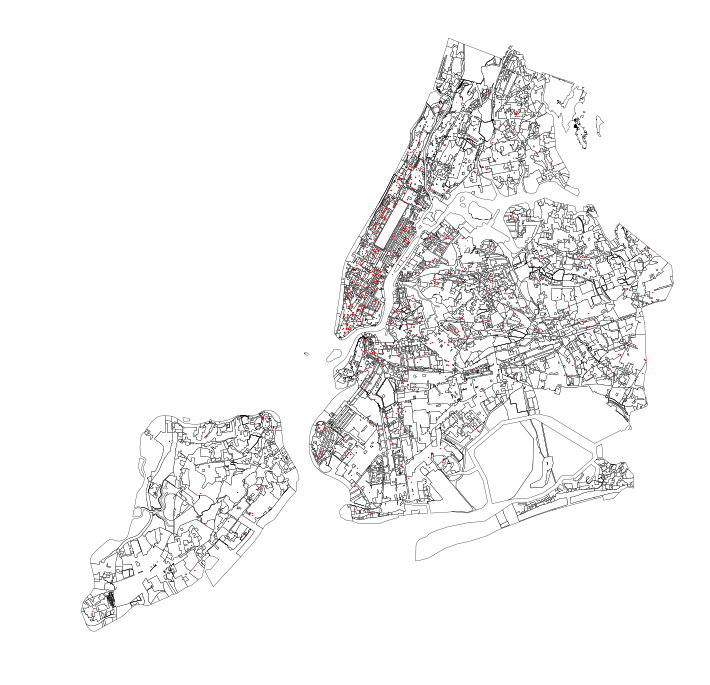

In [1052]:
base = nyzd_19.plot(figsize=(12,12),color='white',edgecolor='black')
base.axis('off')
complaints19.plot(ax=base,markersize=1,color='red')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


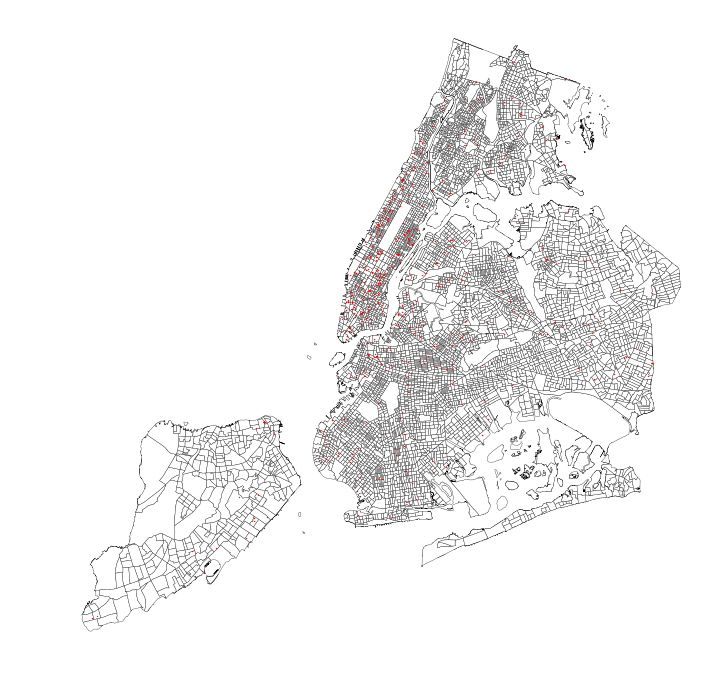

In [1053]:
base = census_df_2017.plot(figsize=(12,12),color='white',edgecolor='black')
base.axis('off')
complaints19.plot(ax=base,markersize=1,color='red')

In [1054]:
nyzd_19.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

In [1055]:
complaints19.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unique Key', 'Created Date',
       'Closed Date', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor',
       'Location Type', 'Incident Zip', 'Incident Address', 'Street Name',
       'Cross Street 1', 'Cross Street 2', 'Intersection Street 1',
       'Intersection Street 2', 'Address Type', 'City', 'Landmark',
       'Facility Type', 'Status', 'Due Date', 'Resolution Description',
       'Resolution Action Updated Date', 'Community Board', 'BBL', 'Borough',
       'X Coordinate (State Plane)', 'Y Coordinate (State Plane)',
       'Open Data Channel Type', 'Park Facility Name', 'Park Borough',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Latitude', 'Longitude', 'Location', 'AHV',
       'lonlat', 'geometry'],
      dtype='object')

In [1056]:
complaints19.dropna(subset=['geometry','Latitude', 'Longitude'],inplace=True)

In [1057]:
nyzd_19 = nyzd_19.to_crs(epsg=2263)
df_zoned_19 = gpd.sjoin(complaints19,nyzd_19,how='left')

In [1058]:
df_zoned_19.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unique Key', 'Created Date',
       'Closed Date', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor',
       'Location Type', 'Incident Zip', 'Incident Address', 'Street Name',
       'Cross Street 1', 'Cross Street 2', 'Intersection Street 1',
       'Intersection Street 2', 'Address Type', 'City', 'Landmark',
       'Facility Type', 'Status', 'Due Date', 'Resolution Description',
       'Resolution Action Updated Date', 'Community Board', 'BBL', 'Borough',
       'X Coordinate (State Plane)', 'Y Coordinate (State Plane)',
       'Open Data Channel Type', 'Park Facility Name', 'Park Borough',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Latitude', 'Longitude', 'Location', 'AHV',
       'lonlat', 'geometry', 'index_right', 'ZONEDIST', 'Shape_Leng',
       'Shape_Area'],
      dtype='object')

In [1059]:
df_zoned_19.drop(['index_right'],axis=1, inplace=True)

In [1060]:
df_zoned_census_2019 = gpd.sjoin(df_zoned_19,census_df_2017,how='left')
df_zoned_census_2019.drop(['index_right'],axis=1, inplace=True)

In [1061]:
df_zoned_census_pluto_2019 = gpd.sjoin(df_zoned_census_2019,pluto_features,how='left')
df_zoned_census_pluto_2019.drop(['index_right'],axis=1, inplace=True)

In [1062]:
weather_2019.head()

,date,average_temparature,snow_levels,precipitation_levels
675,2019-01-01,51.0,0.0,0.08
676,2019-01-02,39.0,0.0,0.00
677,2019-01-03,41.0,0.0,0.00
678,2019-01-04,41.0,0.0,0.00
679,2019-01-05,44.0,0.0,0.45


In [1063]:
df_zoned_census_pluto_2019['Created Date'] = pd.to_datetime(df_zoned_census_pluto_2019['Created Date'])
df_zoned_census_pluto_2019['created_date_wo_time'] = df_zoned_census_pluto_2019['Created Date'].dt.date
df_zoned_census_pluto_2019 = pd.merge(df_zoned_census_pluto_2019, weather_2019,left_on='created_date_wo_time',\
                                      right_on='date')

In [1064]:
df_zoned_census_pluto_2019['hour_of_the_day'] = df_zoned_census_pluto_2019['Created Date'].dt.hour
df_zoned_census_pluto_2019['zonedist_cat'] = df_zoned_census_pluto_2019['ZONEDIST'].apply(lambda x :zonedist_dict[x])
df_zoned_census_pluto_2019['Descriptor_cat'] = df_zoned_census_pluto_2019.Descriptor.apply(lambda x: descriptor_dict[x])

In [1065]:
df_zoned_census_pluto_2019.loc[df_zoned_census_pluto_2019.Descriptor.isin([
       'Noise: Private Carting Noise (NQ1)', 'Noise, Barking Dog (NR5)',
       'Noise, Ice Cream Truck (NR4)', 'Noise: Alarms (NR3)',
       'Noise, Other Animals (NR6)',
       'Noise: air condition/ventilation equipment (NV1)',
       'Noise:  lawn care equipment (NCL)',
       'Noise: Boat(Engine,Music,Etc) (NR10)',
       'Noise: Manufacturing Noise (NK1)']), 'AHV'] = 0

In [1066]:
final_selected_columns

['hour_of_the_day',
 'average_temparature',
 'Descriptor_cat',
 'zonedist_cat',
 'precipitation_levels',
 'AHV',
 'unitstotal',
 'lotdepth',
 'B01002Ae3',
 'snow_levels']

In [1067]:
df_zoned_census_pluto_2019['Created Date'] = pd.to_datetime(df_zoned_census_pluto_2019['Created Date'])
df_zoned_census_pluto_2019['Created Hour'] = df_zoned_census_pluto_2019['Created Date'].dt.hour
df_zoned_census_pluto_2019['Created Dow'] = df_zoned_census_pluto_2019['Created Date'].dt.dayofweek

In [1068]:
df_zoned_census_pluto_2019['During Hours'] = 0

In [1069]:
df_zoned_census_pluto_2019.loc[df_zoned_census_pluto_2019['Created Hour'].isin([7,8,9,10,11,12,13,14,15,16,17,18]) & \
                          df_zoned_census_pluto_2019['Created Dow'].isin([0,1,2,3,4]), 'During Hours'] = 1

In [1070]:
df_zoned_census_pluto_2019.Descriptor.unique()

array(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Private Carting Noise (NQ1)', 'Noise, Barking Dog (NR5)',
       'Noise, Ice Cream Truck (NR4)', 'Noise: Alarms (NR3)',
       'Noise: Jack Hammering (NC2)', 'Noise, Other Animals (NR6)',
       'Noise: air condition/ventilation equipment (NV1)',
       'Noise:  lawn care equipment (NCL)',
       'Noise: Boat(Engine,Music,Etc) (NR10)',
       'Noise: Manufacturing Noise (NK1)'], dtype=object)

In [1071]:
df_zoned_census_pluto_2019[(df_zoned_census_pluto_2019['During Hours'] == 0) & (df_zoned_census_pluto_2019.Descriptor.isin(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)'])) & (df_zoned_census_pluto_2019.AHV == 0)].shape

(215, 735)

In [1072]:
df_zoned_census_pluto_2019.shape

(686, 735)

In [1073]:
closed_complaints = df_zoned_census_pluto_2019.dropna(subset=['Resolution Description'])
closed_complaints['enforcability_score'] = closed_complaints['Resolution Description'].dropna().apply(lambda x: dict3[x])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [1074]:
closed_complaints = closed_complaints[closed_complaints['enforcability_score'] != 0]

In [1075]:
open_complaints = df_zoned_census_pluto_2019[df_zoned_census_pluto_2019['Resolution Description'].isnull()]

In [1076]:
closed_complaints['Predicted Enforcability Probability'] = [item[0] for item in final_model_with_selected.predict_proba(\
                                                                                       closed_complaints[final_selected_columns])]
closed_complaints['Predicted Enforcability Score'] = final_model_with_selected.predict(\
                                                                                       closed_complaints[final_selected_columns])

In [1077]:
open_complaints['Predicted Enforcability Probability'] = [item[0] for item in final_model_with_selected.predict_proba(\
                                                                                       open_complaints[final_selected_columns])]
open_complaints['Predicted Enforcability Score'] = final_model_with_selected.predict(\
                                                                                       open_complaints[final_selected_columns])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Following the meeting with the DEP

Based on the DEP's feedback we have given higher scores to both complaints that have an AHV permit nearby and are after hours complaints about construction without a permit.
They also hoped to be able to filter construction complaints close to each other that may indicate they are from the same source. This method helped us incorporate the enforceability score predicted by the model while also making use of the DEP's domain knowledge.

In [180]:
closed_complaints['New Predicted Enforcability Probability'] = 0
for index, i in closed_complaints.iterrows():
    if ((i['During Hours']==0) & (i['AHV']==0)\
                     & (i.Descriptor in(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)']))):
        closed_complaints['New Predicted Enforcability Probability'].loc[index] = 0.8 + (0.2*i['Predicted Enforcability Probability'])
    elif ((i['During Hours']==0) & (i['AHV']==1)\
                     & (i.Descriptor in(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)']))):
        closed_complaints['New Predicted Enforcability Probability'].loc[index] = 0.6 + (0.4*i['Predicted Enforcability Probability']) 
    else:
        closed_complaints['New Predicted Enforcability Probability'].loc[index] = i['Predicted Enforcability Probability']

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [181]:
closed_complaints[(closed_complaints['New Predicted Enforcability Probability'] > \
                  closed_complaints['Predicted Enforcability Probability']) & (closed_complaints['AHV'] ==1)].head()

,Unnamed: 0,Unnamed: 0.1,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,...,hour_of_the_day,zonedist_cat,Descriptor_cat,Created Hour,Created Dow,During Hours,enforcability_score,Predicted Enforcability Probability,Predicted Enforcability Score,New Predicted Enforcability Probability
16,16,96,43107804,2019-06-26 20:45:00,06/27/2019 11:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,20,32,0,20,2,0,2,0.19,2,0.676
62,62,142,43122219,2019-06-26 23:25:00,06/27/2019 07:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,23,38,0,23,2,0,2,0.10,2,0.640
85,4,164,43125774,2019-06-26 22:19:00,06/27/2019 09:52:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,22,42,0,22,2,0,2,0.27,2,0.708
86,5,165,43125775,2019-06-26 22:10:00,06/27/2019 11:15:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,22,38,0,22,2,0,2,0.08,2,0.632
88,7,167,43125777,2019-06-26 01:35:00,06/29/2019 08:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,1,30,0,1,2,0,2,0.21,2,0.684


In [182]:
open_complaints['New Predicted Enforcability Probability'] = 0
for index, i in open_complaints.iterrows():
    if ((i['During Hours']==0) & (i['AHV']==0)\
                     & (i.Descriptor in(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)']))):
        open_complaints['New Predicted Enforcability Probability'].loc[index] = 0.8 + (0.2*i['Predicted Enforcability Probability'])
    elif ((i['During Hours']==0) & (i['AHV']==1)\
                     & (i.Descriptor in(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)']))):
        open_complaints['New Predicted Enforcability Probability'].loc[index] = 0.6 + (0.4*i['Predicted Enforcability Probability']) 
    else:
        open_complaints['New Predicted Enforcability Probability'].loc[index] = i['Predicted Enforcability Probability']

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

In [268]:
closed_complaints[closed_complaints.Descriptor.isin(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)'])].shape

(304, 739)

We then assigned if there are construction complaints close to each other

In [270]:
def return_dist(complaint_lat,complaint_lon,ahv_lat,ahv_lon):
    from math import sin, cos, sqrt, atan2, radians
   # approximate radius of earth in km
    R = 6373.0
    lat1 = radians(complaint_lat)
    lon1 = radians(complaint_lon)
    lat2 = radians(ahv_lat)
    lon2 = radians(ahv_lon)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return(distance*1000)

In [ ]:
closed_complaints.Longitude,

In [276]:
closed_complaints['nearby_complaint'] = 0
for index1,i in closed_complaints[closed_complaints.Descriptor.isin(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)'])].iterrows():
    for index2 , j in closed_complaints[closed_complaints.Descriptor.isin(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)'])].iterrows():
        # We picked up 300 metres as the approxiamate distance between two consecutive blocks
        if(index1 != index2) & (return_dist(i['Latitude'],i['Longitude'],j['Latitude'],j['Longitude'])<300):
            closed_complaints['nearby_complaint'].loc[index1] = 1

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [284]:
open_complaints['nearby_complaint'] = 0
for index1,i in open_complaints[open_complaints.Descriptor.isin(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)'])].iterrows():
    for index2 , j in open_complaints[open_complaints.Descriptor.isin(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)'])].iterrows():
        # We picked up 300 metres as the approxiamate distance between two consecutive blocks
        if(index1 != index2) & (return_dist(i['Latitude'],i['Longitude'],j['Latitude'],j['Longitude'])<300):
            open_complaints['nearby_complaint'].loc[index1] = 1

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

In [280]:
closed_complaints[closed_complaints.nearby_complaint == 1].shape

(130, 740)

In [285]:
open_complaints[list(complaints19.columns)+final_selected_columns+['Predicted Enforcability Probability',\
                                          'Predicted Enforcability Score','New Predicted Enforcability Probability',\
                                                                   'nearby_complaint']].\
to_csv('tableau_input_files/open_complaints.csv',\
                                                                                   index=False)

In [282]:
closed_complaints[list(complaints19.columns)+\
                  final_selected_columns+['enforcability_score','Predicted Enforcability Probability',\
                                          'Predicted Enforcability Score','New Predicted Enforcability Probability'\
                                          ,'nearby_complaint']]\
.to_csv('tableau_input_files/closed_complaints.csv',\
                                                                                   index=False)

In [185]:
closed_complaints[(closed_complaints['enforcability_score'] == 1) &\
                  (closed_complaints['New Predicted Enforcability Probability'] > 0.5)].shape

(6, 739)

In [186]:
closed_complaints[(closed_complaints['enforcability_score'] == 1) &\
                  (closed_complaints['Predicted Enforcability Probability'] > 0.5)].shape

(1, 739)

In [ ]:
closed_complaints.Descriptor.isin()

In [191]:
closed_complaints[closed_complaints['enforcability_score']==1].sort_values(by='Predicted Enforcability Probability',\
                                                                                        ascending=False)

,Unnamed: 0,Unnamed: 0.1,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,...,hour_of_the_day,zonedist_cat,Descriptor_cat,Created Hour,Created Dow,During Hours,enforcability_score,Predicted Enforcability Probability,Predicted Enforcability Score,New Predicted Enforcability Probability
371,32,512,43167866,2019-07-01 06:43:00,07/02/2019 06:45:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,6,4,0,6,0,0,1,0.63,1,0.926
154,63,63,43100509,2019-06-26 06:57:00,06/27/2019 07:30:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,6,22,0,6,2,0,1,0.43,2,0.886
341,95,815,43166181,2019-07-01 06:43:00,07/08/2019 07:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,6,11,0,6,0,0,1,0.42,2,0.884
365,25,505,43167023,2019-07-01 20:54:00,07/03/2019 12:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,20,22,0,20,0,0,1,0.34,2,0.868
390,51,531,43169541,2019-07-01 02:51:00,07/01/2019 11:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,2,57,0,2,0,0,1,0.31,2,0.862
550,29,669,43181377,2019-07-02 21:57:00,07/03/2019 10:15:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Before/After Hours (NM1),NaN,...,21,154,0,21,1,0,1,0.29,2,0.716


In [192]:
confusion_matrix(closed_complaints['enforcability_score'],final_model_with_selected.predict(closed_complaints[final_selected_columns]))

array([[  1,   5],
       [159, 337]])

In [193]:
f_score(confusion_matrix(closed_complaints['enforcability_score'],final_model_with_selected.predict(closed_complaints[final_selected_columns])))

0.0120481927711


In [194]:
final_model_with_selected.score(closed_complaints[final_selected_columns],closed_complaints['enforcability_score'])

0.67330677290836649

In [195]:
final_model_with_selected.predict(closed_complaints[final_selected_columns])

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2,
       1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1,
       2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2,

# Comparing a model trained on records vs balanced subset

## First the results of the model trained on balanced subset

# Testing for all complaints and selected features

In [196]:
feature_importance = pd.DataFrame(np.array([x_train.columns,model_with_all_features.feature_importances_]).T,\
                                  columns=['Features','Importance'])
final_selected_columns = list(feature_importance.sort_values(by='Importance',ascending=False)[:10].Features)

In [197]:
feature_importance[:10]

,Features,Importance
0,hour_of_the_day,0.194082
1,average_temparature,0.129668
2,precipitation_levels,0.0562936
3,zonedist_cat,0.100919
4,Descriptor_cat,0.0304879
5,AHV,0.0152107
6,assessland,0.145009
7,B01002Im1,0.117062
8,residfar,0.128649
9,B19037m50,0.0826174


In [198]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                      .enforcability_score == 1][final_selected_columns],
                                                    filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto\
                                                                                      .enforcability_score == 1]['enforcability_score'],
                                                           test_size = 0.3,random_state=42)
unenforcable_data = filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto.enforcability_score == 2].sample(n=1470)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(unenforcable_data[final_selected_columns],
                                                    unenforcable_data['enforcability_score'],
                                                           test_size = 0.3,random_state=42)
                                                    

In [199]:
x_train = pd.concat([x_train_1,x_train_2])
x_test = pd.concat([x_test_1,x_test_2])
y_train = pd.concat([y_train_1,y_train_2])
y_test = pd.concat([y_test_1,y_test_2])

In [200]:
final_model_with_selected = RandomForestClassifier(random_state=0,n_estimators=100)
final_model_with_selected.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [201]:
final_model_with_selected.score(x_test,y_test)

0.70634920634920639

In [202]:
y_pred = final_model_with_selected.predict(x_test)

In [203]:
confusion_matrix(y_pred,y_test)

array([[317, 135],
       [124, 306]])

In [204]:
f_score(confusion_matrix(y_pred,y_test))

0.709966405375


In [205]:
(389.2+4364.6)/13900

0.342

In [206]:
subset = filtered_combined_df_added_census_pluto.sample(n=1000,random_state=42)
confusion_matrix(final_model_with_selected.predict(subset[final_selected_columns]),
                 subset['enforcability_score'])

array([[ 31, 310],
       [  3, 656]])

In [207]:
f_score(confusion_matrix(final_model_with_selected.predict(subset[final_selected_columns]),
                 subset['enforcability_score']))

0.165333333333


# Testing for all complaints and selected features without balanced training

In [208]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(filtered_combined_df_added_census_pluto[final_selected_columns],
                                                    filtered_combined_df_added_census_pluto['enforcability_score'],
                                                           test_size = 0.3,random_state=42)

In [209]:
final_model_with_selected1 = RandomForestClassifier(random_state=0,n_estimators=100)
final_model_with_selected1.fit(x_train1, y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [210]:
final_model_with_selected1.score(x_test1,y_test1)

0.97035971223021578

In [211]:
y_pred1 = final_model_with_selected1.predict(x_test1)

In [212]:
confusion_matrix(y_pred1,y_test1)

array([[   35,    17],
       [  395, 13453]])

In [213]:
f_score(confusion_matrix(y_pred1,y_test1))

0.145228215768


In [214]:
(389.2+4364.6)/13900

0.342

In [215]:
subset = filtered_combined_df_added_census_pluto.sample(n=10000,random_state=42)
confusion_matrix(final_model_with_selected.predict(subset[final_selected_columns]),
                 subset['enforcability_score'])

array([[ 281, 3142],
       [  29, 6548]])

In [216]:
confusion_matrix(final_model_with_selected1.predict(subset[final_selected_columns]),
                 subset['enforcability_score'])

array([[  28,   15],
       [ 282, 9675]])

In [217]:
subset['predicted_enforceability'] = final_model_with_selected1.predict(subset[final_selected_columns])

In [218]:
borough_df = gpd.GeoDataFrame.from_file('Borough_Boundaries/geo_export_dfd4c712-f0cc-4c26-9e6f-a9244b2f7559.shp')

In [219]:
borough_df = borough_df.to_crs(epsg=2263)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


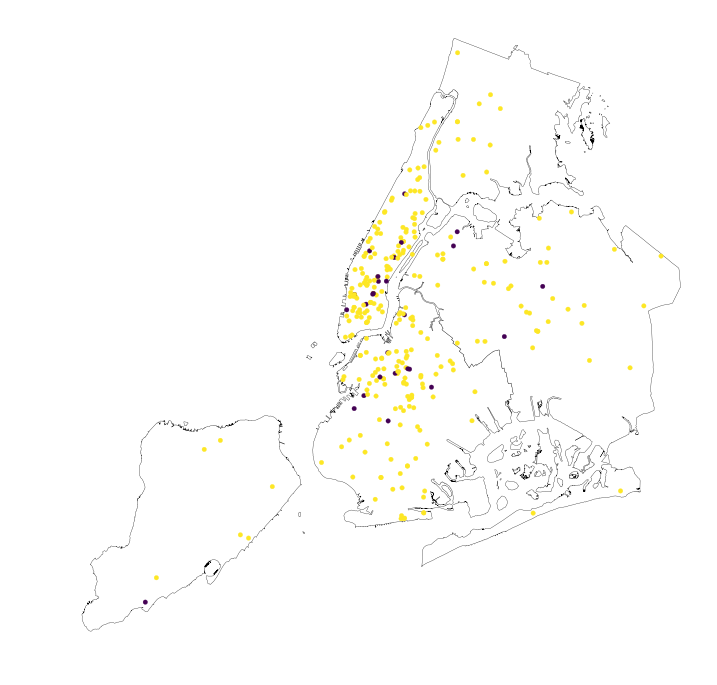

In [220]:
base = borough_df.plot(figsize=(12,12),color='white',edgecolor='black')
base.axis('off')
subset[subset['enforcability_score']==1].plot(ax=base,markersize=20,column='predicted_enforceability',cmap='viridis')
plt.savefig('old_model.png')

In [221]:
subset['predicted_enforceability'] = final_model_with_selected.predict(subset[final_selected_columns])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


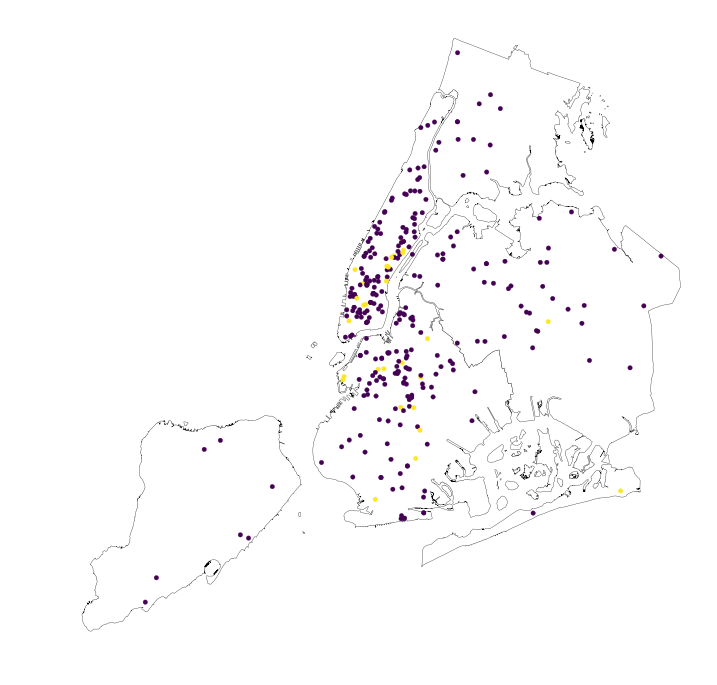

In [222]:
base = borough_df.plot(figsize=(12,12),color='white',edgecolor='black')
base.axis('off')
subset[subset['enforcability_score']==1].plot(ax=base,markersize=20,column='predicted_enforceability',cmap='viridis')
plt.savefig('new_model.png')

In [223]:
subset[subset['enforcability_score'] == 1].shape

(310, 747)

In [225]:
conf_mat = confusion_matrix(final_model_with_selected.predict(subset[final_selected_columns]),
                 subset['enforcability_score'])
print("The precision is "+str(conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])))

The precision is 0.906451612903


In [226]:
print("The recall is "+str(conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])))

The recall is 0.0820917323985


In [227]:
f_score(conf_mat)

0.150549156175


In [233]:
closed_complaints['Predicted Enforcability Probability'] = [item[0] for item in final_model_with_selected.predict_proba(\
                                                                                       closed_complaints[final_selected_columns])]
closed_complaints['Predicted Enforcability Score'] = final_model_with_selected.predict(\
                                                                                       closed_complaints[final_selected_columns])

In [234]:
confusion_matrix(closed_complaints['enforcability_score'],closed_complaints['Predicted Enforcability Score'])

array([[  1,   5],
       [110, 386]])

In [235]:
filtered_combined_df_added_census_pluto['predicted_enforcability_prob'] = [item[0] for item in final_model_with_selected.predict_proba(filtered_combined_df_added_census_pluto[final_selected_columns])]

In [236]:
filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto['predicted_enforcability_prob']>0.90].shape

(779, 747)

In [237]:
filtered_combined_df_added_census_pluto[(filtered_combined_df_added_census_pluto['predicted_enforcability_prob']>0.90)\
                                       & (filtered_combined_df_added_census_pluto['enforcability_score'] == 1)].shape

(378, 747)

In [238]:
filtered_combined_df_added_census_pluto.sort_values(by='predicted_enforcability_prob',ascending=False)[:10].geometry

1141     POINT (988266.9999976143 183423.0143915525)
41471    POINT (1009993.999984679 235682.0144250781)
11405    POINT (988765.9999973287 184210.0143920672)
23611    POINT (995866.9999931153 198616.0144013965)
20768    POINT (995993.9999930346 198830.0144015479)
21477    POINT (1001299.999989882 202986.0144042304)
39829    POINT (1016920.999980608 209814.0144085893)
34218    POINT (1033286.999970922 194943.0143989703)
1931     POINT (988931.9999972304 180667.0143897517)
2352      POINT (1003203.999988779 182959.014391242)
Name: geometry, dtype: object

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


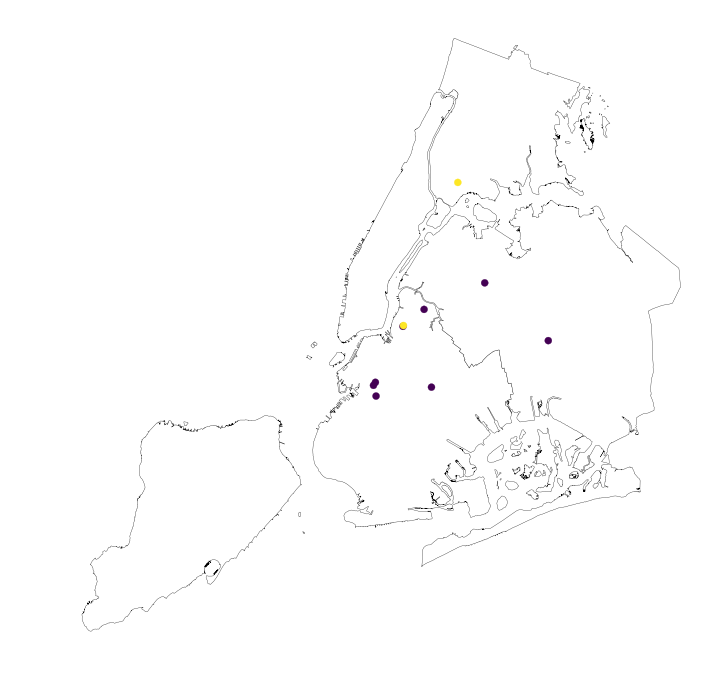

In [239]:
base = borough_df.plot(figsize=(12,12),color='white',edgecolor='black')
base.axis('off')
filtered_combined_df_added_census_pluto.sort_values(by='predicted_enforcability_prob',ascending=False)[:10]\
.plot(ax=base,markersize=50,column='enforcability_score',cmap='viridis')
plt.savefig('top10.png')

In [240]:
df_zoned_census_pluto_2019.Descriptor.unique()

array(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Private Carting Noise (NQ1)', 'Noise, Barking Dog (NR5)',
       'Noise, Ice Cream Truck (NR4)', 'Noise: Alarms (NR3)',
       'Noise: Jack Hammering (NC2)', 'Noise, Other Animals (NR6)',
       'Noise: air condition/ventilation equipment (NV1)',
       'Noise:  lawn care equipment (NCL)',
       'Noise: Boat(Engine,Music,Etc) (NR10)',
       'Noise: Manufacturing Noise (NK1)'], dtype=object)

In [241]:
df_zoned_census_pluto_2019[df_zoned_census_pluto_2019.Descriptor.isin([
       'Noise: Private Carting Noise (NQ1)', 'Noise, Barking Dog (NR5)',
       'Noise, Ice Cream Truck (NR4)', 'Noise: Alarms (NR3)',
       'Noise, Other Animals (NR6)',
       'Noise: air condition/ventilation equipment (NV1)',
       'Noise:  lawn care equipment (NCL)',
       'Noise: Boat(Engine,Music,Etc) (NR10)',
       'Noise: Manufacturing Noise (NK1)'])].AHV.unique()

array([0])

# Boosting probabilities of 2016 complaints

In [242]:
filtered_combined_df_added_census_pluto['Created Date'] = pd.to_datetime(filtered_combined_df_added_census_pluto['Created Date'])
filtered_combined_df_added_census_pluto['Created Hour'] = filtered_combined_df_added_census_pluto['Created Date'].dt.hour
filtered_combined_df_added_census_pluto['Created Dow'] = filtered_combined_df_added_census_pluto['Created Date'].dt.dayofweek

In [243]:
filtered_combined_df_added_census_pluto['During Hours'] = 0
filtered_combined_df_added_census_pluto.loc[filtered_combined_df_added_census_pluto['Created Hour'].isin([7,8,9,10,11,12,13,14,15,16,17,18]) & \
                          filtered_combined_df_added_census_pluto['Created Dow'].isin([0,1,2,3,4]), 'During Hours'] = 1

In [244]:
filtered_combined_df_added_census_pluto.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address',
       ...
       'landuse', 'lottype', 'simple_zone', 'overlay1_cat', 'bldgclass_cat',
       'simple_zone_cat', 'predicted_enforcability_prob', 'Created Hour',
       'Created Dow', 'During Hours'],
      dtype='object', length=750)

In [245]:
filtered_combined_df_added_census_pluto['New Predicted Enforcability Probability'] = 0
for index, i in filtered_combined_df_added_census_pluto.iterrows():
    if ((i['During Hours']==0) & (i['AHV']==0)\
                     & (i.Descriptor in(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)']))):
        filtered_combined_df_added_census_pluto['New Predicted Enforcability Probability'].loc[index] = \
        0.8 + (0.2*i['predicted_enforcability_prob'])
    elif ((i['During Hours']==0) & (i['AHV']==1)\
                     & (i.Descriptor in(['Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)']))):
        filtered_combined_df_added_census_pluto['New Predicted Enforcability Probability'].loc[index] = \
        0.6 + (0.4*i['predicted_enforcability_prob']) 
    else:
        filtered_combined_df_added_census_pluto['New Predicted Enforcability Probability'].loc[index] = \
        i['predicted_enforcability_prob']

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [258]:
filtered_combined_df_added_census_pluto\
[(filtered_combined_df_added_census_pluto['New Predicted Enforcability Probability']>=0.5) &\
 (filtered_combined_df_added_census_pluto['enforcability_score'] == 1)]\
.shape

(1403, 752)

In [261]:
filtered_combined_df_added_census_pluto\
[(filtered_combined_df_added_census_pluto['New Predicted Enforcability Probability']<0.5) &\
 (filtered_combined_df_added_census_pluto['enforcability_score'] == 1)]\
.shape

(67, 752)

In [263]:
1403/(1403+28810)

0.0464369642206997

In [ ]:
confusion_matrix(filtered_combined_df_added_census_pluto['enforcability_score'],\
                 filtered_combined_df_added_census_pluto['New Predicted Enforcability Score'])

In [287]:
filtered_combined_df_added_census_pluto[filtered_combined_df_added_census_pluto['enforcability_score'] == 1].shape

(1470, 752)

In [288]:
filtered_combined_df_added_census_pluto.shape

(46332, 752)